# Exploring OOI data access

Still not sure how everything works, so this script is going to be my exploration into loading broadband hydrophone data.

I'm using this notebook as an example: https://github.com/petercable/noisy-dolphins/blob/master/Voices.ipynb 

But rather than loading up one specific file, I'm interested in providing the user with a way to explore the available data a little bit. I plan to use beautiful soup to scrape the particular corner of the OOI raw data website that I'm interested in. It may not be the best way to do it but I currently don't know a better way so here we go!

In [77]:
import obspy
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
from dateutil import parser
import pandas as pd
from scipy.signal import spectrogram

## Setting up and scraping data

I'm starting by specifying the URL to the page I'm interested in. (I've also specified a particular miniseed file but commenting that out for now).

In [4]:
# url_mseed = 'https://rawdata.oceanobservatories.org/files/RS03AXBS/LJ03A/09-HYDBBA302/2020/12/05/OO-AXVM1--YDH-2020-12-05T14:30:00.000015.mseed'
# print('The requested URL: ' + url_mseed)

page_url = 'https://rawdata.oceanobservatories.org/files/RS03AXBS/LJ03A/09-HYDBBA302/2020/12/05/'
page = requests.get(page_url).content

# Specify the sampling frequency
fs = 64000

Now I'll use beautiful soup to parse the contents of the page.

In [5]:
soup = BeautifulSoup(page, 'html.parser')
# Uncomment to see the full html
# print(soup.prettify()) 
# pull out every link on the page
all_links = [link.get('href') for link in soup.find_all('a')]
mseed_files = [i for i in all_links if '.mseed' in i]

## Load miniseed data

Now that we have a list of the miniseed files on the current page, let's try actually reading the data from just one of those miniseed files.

In [6]:
mseed_data_url = page_url + mseed_files[0].split('./')[1]
stream = obspy.read(mseed_data_url, ssl_verify=False)  # Fetch from data server
# Pull out the raw data
dat = stream[0].data
# Generate a time vector using the sample frequency
tvec = np.arange(0,len(dat)/fs,1/fs)

## Quick plot
Plotting about 16 seconds of data (the first million points!! eep!)

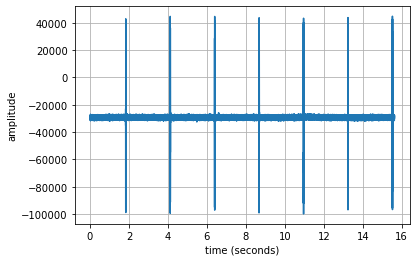

In [7]:
plt.plot(tvec[0:1000000],dat[0:1000000])
plt.xlabel('time (seconds)')
plt.ylabel('amplitude')
plt.grid()

Ok then, not bad for a first stab at this. We got some data loaded and plotted! That's great! But it is weird and noisy and not very exciting to look at so...

Next up: 
- figure out what those blips are every 2 seconds and determine whether I can easily filter them out. I'll probably start by exploring a spectrogram view
- use hvplot (etc) to make the plots in here interactive
- Decimation! (who needs 32 kHz anyway?? Anyone worth listening to is under 1 kHz, amirite??
- Pulling together multiple mseeds, decimating, pasting together?
- Maybe loop through multiple days of mseeds (or look at a few out of each day) and see if I can pull out interesting statistics or features (earthquakes? whale calls?)

## Test load in summary dataframe

Now that we've at least partially created a lookup table (using ooi_crawler.py in this repository), we can start using it to explore the acoustic data. We'll start by loading and looking at the last few rows of the dataframe.

In [52]:
path_to_df = '../../data/ooi_lookup/ooi_lookup.pkl'
df = pd.read_pickle(path_to_df)
df.tail()

,filepath,filename,starttime
6574,https://rawdata.oceanobservatories.org/files/R...,OO-AXVM1--YDH-2019-06-30T23:35:00.000000.mseed,2019-06-30 23:35:00
6575,https://rawdata.oceanobservatories.org/files/R...,OO-AXVM1--YDH-2019-06-30T23:40:00.000000.mseed,2019-06-30 23:40:00
6576,https://rawdata.oceanobservatories.org/files/R...,OO-AXVM1--YDH-2019-06-30T23:45:00.000000.mseed,2019-06-30 23:45:00
6577,https://rawdata.oceanobservatories.org/files/R...,OO-AXVM1--YDH-2019-06-30T23:50:00.000000.mseed,2019-06-30 23:50:00
6578,https://rawdata.oceanobservatories.org/files/R...,OO-AXVM1--YDH-2019-06-30T23:55:00.000000.mseed,2019-06-30 23:55:00


This is great but now we need to figure out how to interact with this dataframe. Everything we need to start looking at the data is here, but what would be most useful? Some ideas:

- Pull out everything within a date range, specified by start and end date/time
- Probably put the functions for interacting with this dataset into a python script that we can load
- Make sure the requested date range has data in it
- Do we want every file within a date range? A certain number of files per day/month?

## Load a miniseed file and explore

In [66]:
def load_mseed(ooi_lookup_row, **kwargs):
    '''
    load_mseed
    Load a miniseed file based on information contained in a row from the dataframe contained within the ooi_lookup.pkl file
    
    :param ooi_lookup_row: (pandas series) row extracted from the ooi_lookup dataframe
    
    :return dat: (numpy array) amplitude time series, interval = 1/fs
    :return fs: (int) samples per second (Hz)
    :return starttime: () start date and time of the current data stream
    :return endtime: () end date and time of the current data stream
    '''
    mseed_data_url = ooi_lookup_row['filepath'] + ooi_lookup_row['filename']
    stream = obspy.read(mseed_data_url, ssl_verify=False)  # Fetch from data server
    # Pull out the raw data
    dat = stream[0].data
    fs = stream.traces[0].stats.sampling_rate
    starttime = stream.traces[0].stats.starttime
    endtime = stream.traces[0].stats.endtime
    
    return dat, fs, starttime, endtime

Pull a row out of the ooi_lookup dataframe, pass it to the load_mseed function, and print a summary of based on what is returned.

In [74]:
dat, fs, stime, etime = load_mseed(df.iloc[6575])
print('Sample rate is: ' + str(fs))
print('Start time of the file: ' + str(stime))
print('End time of file: ' + str(etime))

Sample rate is: 64000.0
Start time of the file: 2016-01-11T07:15:00.000015Z
End time of file: 2016-01-11T07:19:59.998984Z


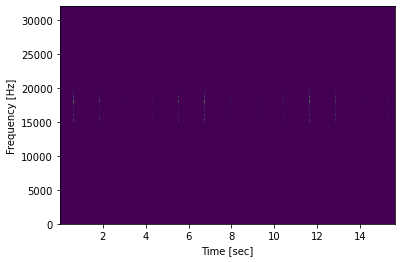

In [80]:
f, t, Sxx = spectrogram(dat[0:1000000], fs)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

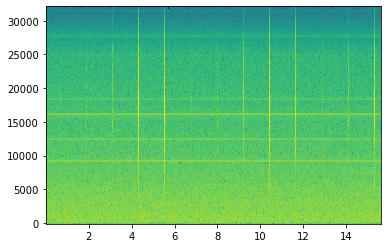

In [84]:
test = 10*np.log10(Sxx)
plt.pcolormesh(t, f, test, shading='auto')